In [1]:
try:
    # if this notebook is being called by another one
    # used passed gene_name value
    gene_name
    enriched_test
    threshold_df
except:
    # otherwise, set value to amacGFP / avGFP / cgreGFP / ppluGFP,
    # for instance for debugging here
    gene_name="avGFP"
    enriched_test=False
    threshold_df = ''



In [2]:

if not gene_name.endswith("GFP"):
    gene_name = gene_name+"GFP"

In [3]:
# if load_encodings (boolean)
# exists and is False, encodings won't be loaded
# if not defined or not False, load encodings
try:
    load_encodings
    if load_encodings != False:
        load_encodings = True
except:
    load_encodings = True

Import modules
Define functions
Load avGFP data
avGFP 239 aa


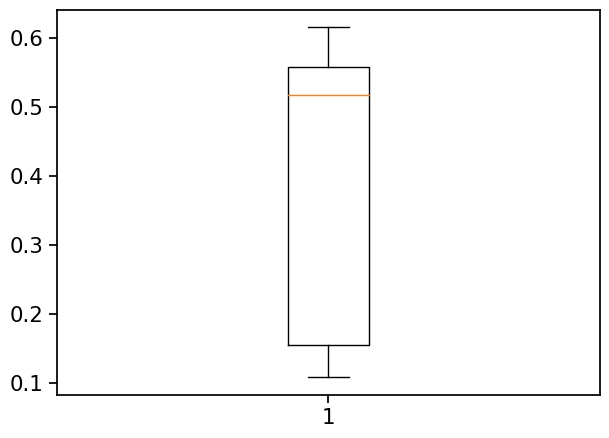

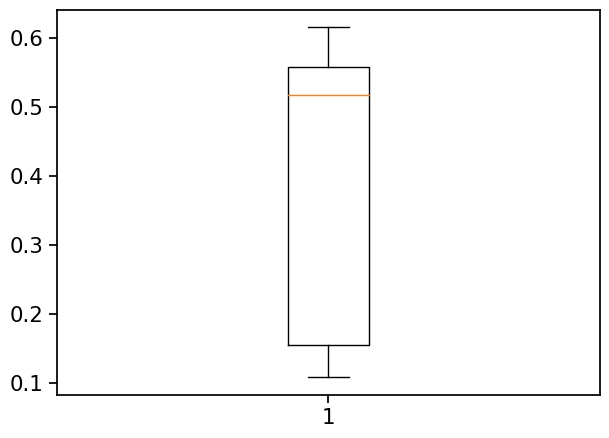

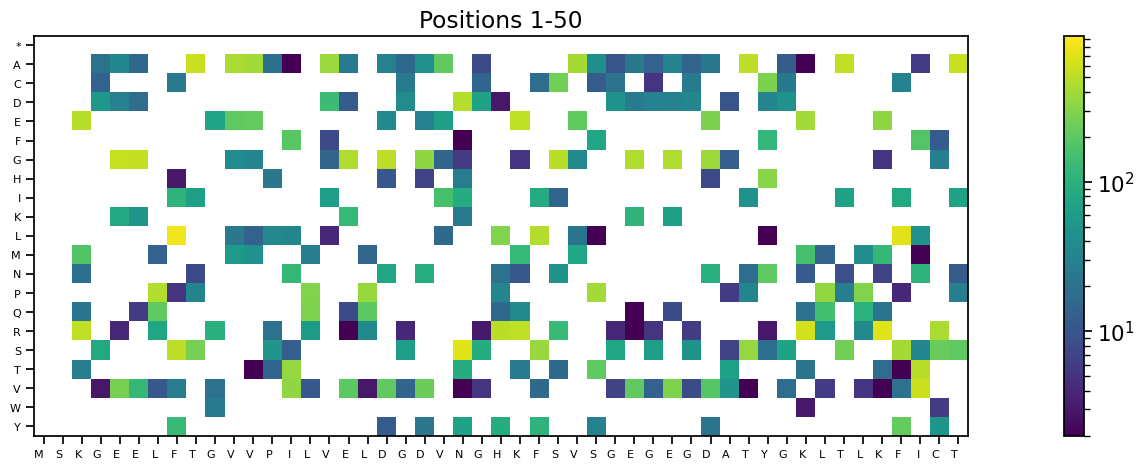

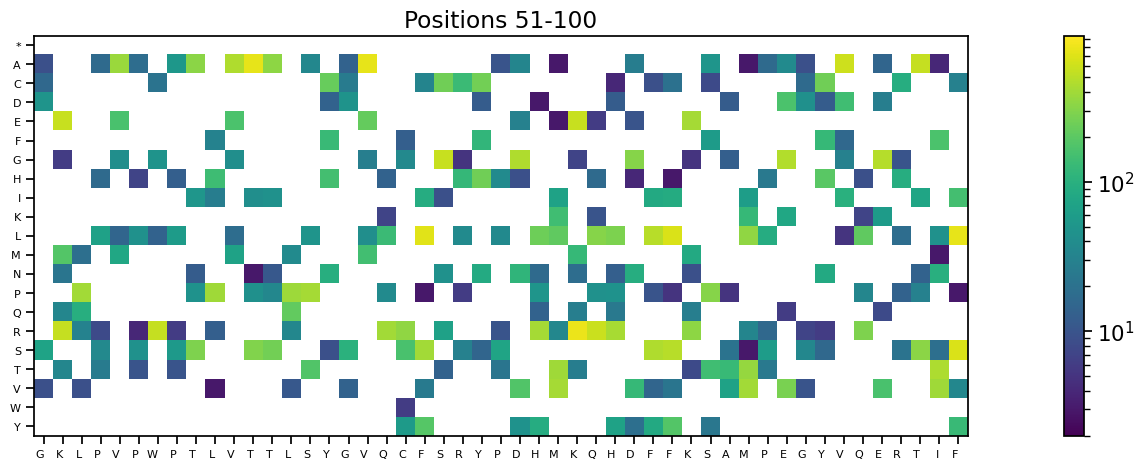

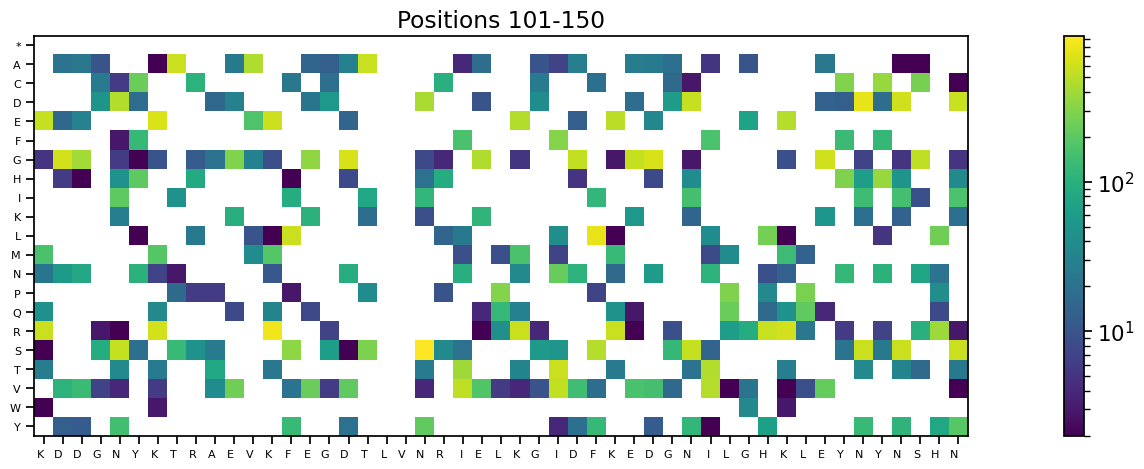

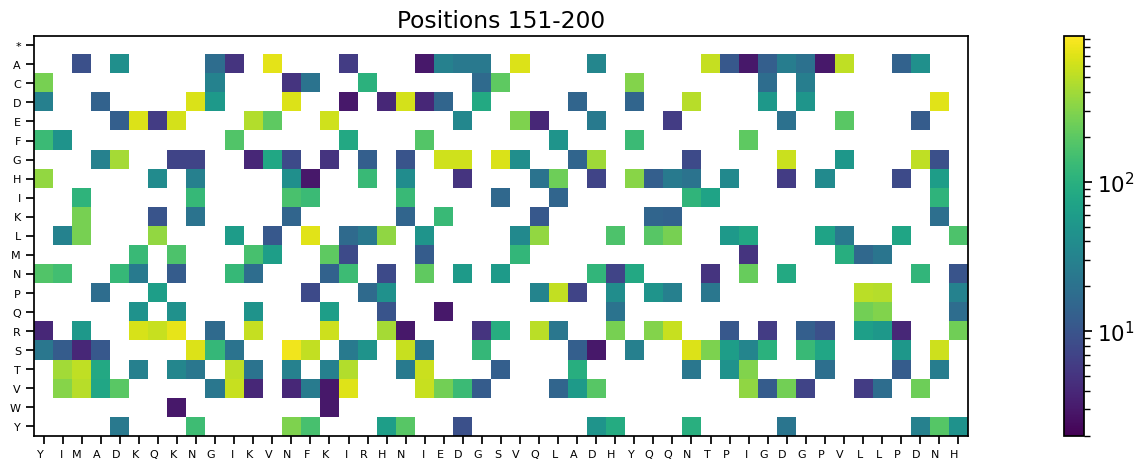

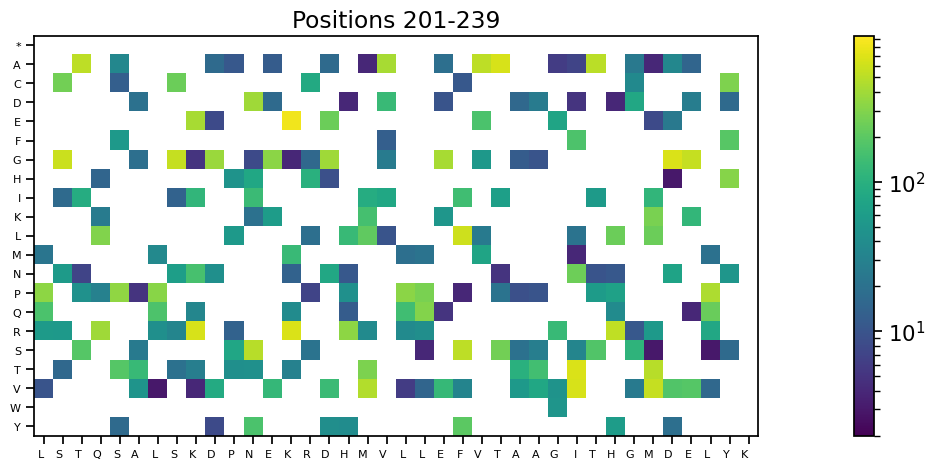

In [4]:
%run 01_Load_data.ipynb

In [5]:
# function to reverse oneHot encoding, making sure everything is OK
def one_hot_to_seq(df):

    seqs = []
    cols = df.columns
    for index, row in df.iterrows():
        seq = str()
        for i in range(len(row)):
            if row[i] == 1:
                seq = seq+cols[i][-1]

        seqs.append(seq)

    seqs = pd.DataFrame(seqs, columns=["rebuilt_seq"])
    return(seqs)


#### preprocessing


In [6]:
print(f"Pre-processing {gene_name}")

Pre-processing avGFP


In [7]:
df["full_seq"] = get_seq_from_genotype.fit_transform(df)

#### Load encodings

In [8]:
# df_ = df.head(20)
# df_
df

,aaMutations,medianBrightness,aa_genotype_pseudo,full_seq
0,wt,3.719212,wt,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
1,A109D,1.301030,A113D,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
2,A109D:N145D:I187V:M232T:L235P,1.301031,A113D:N149D:I191V:M240T:L243P,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
3,A109D:Y142N:H147L:E221G,1.301189,A113D:Y146N:H151L:E229G,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
4,A109G,3.708478,A113G,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
...,...,...,...,...
54020,Y91N:N104S:I170F,1.552090,Y95N:N108S:I174F,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
54021,Y91N:Q176L:L206Q:T229A:M232V,1.301030,Y95N:Q180L:L213Q:T237A:M240V,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
54022,Y91R:I151N:N197S,1.301030,Y95R:I155N:N204S,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
54023,Y91R:I166T:L235P,1.301517,Y95R:I170T:L243P,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...


#### Split train/valid/test

In [10]:
if threshold_df !='':
    df_sorted = df.sort_values(brightness_col, ascending=False)
    if threshold_df[0] =='<':
        df = df[df[brightness_col] < float(threshold_df[1:])]
    if threshold_df[0] =='>':
        df = df[df[brightness_col] > float(threshold_df[1:])]
df.reset_index(inplace=True, drop=True)


In [11]:
if load_encodings:
    print(f"Load {gene_name} encodings")

    ## get_one_hot_encoding_pl does not work for beamimc // one_hot_encoder is fast enough
    predictors = one_hot_encoder(df)
    cols = [col for col in predictors.columns if "*" not in col]
    predictors = predictors.loc[:,cols]
    
    target = df[[brightness_col]]
    target

Load avGFP encodings


Split train, valid, test sets
train_index 18052
valid_index 6017
test_index 6018


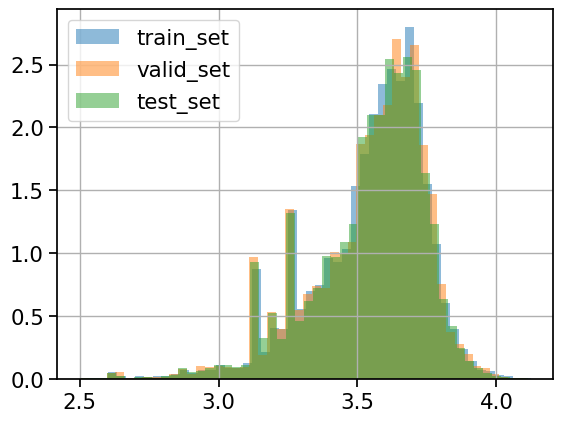

In [12]:

if not enriched_test:
    # First split train, valid, test indexes (not very elegant, yes)
    print("Split train, valid, test sets")

    (predictors_train,
    predictors_valid_test, 
    target_train, 
    target_valid_test) = train_test_split(df.index, 
                                        df.index, 
                                        test_size=0.4, 
                                        random_state=42)

    (predictors_valid, 
    predictors_test, 
    target_valid,
    target_test) = train_test_split(predictors_valid_test, 
                                target_valid_test, 
                                test_size=0.5, 
                                random_state=42)

    train_index = sorted(predictors_train)
    valid_index = sorted(predictors_valid)
    test_index  = sorted(predictors_test)

    # if encodings have been loaded, 
    # split predictors and target data according to indexes above
    if load_encodings:
        
        predictors_train = predictors.loc[train_index]
        predictors_valid = predictors.loc[valid_index]
        predictors_test = predictors.loc[test_index]

        target_train = target.loc[train_index]
        target_valid = target.loc[valid_index]
        target_test = target.loc[test_index]
        
        print("train_index",len(train_index))
        print("valid_index",len(valid_index))
        print("test_index",len(test_index))

        #------------------------------------------------------------
        # check subset sizes and medianBrightness distributions (using density parameter)
        fig, ax = plt.subplots()
        fig.patch.set_facecolor('w')
        
        target_train[brightness_col].hist(alpha=0.5, density=True, bins=50)
        target_valid[brightness_col].hist(alpha=0.5, density=True, bins=50)
        target_test[brightness_col].hist(alpha=0.5, density=True, bins=50)

        # Add a legend
        plt.legend(["train_set", "valid_set", "test_set"])

        # Show the plot
        plt.show()

In [13]:
from sklearn.model_selection import train_test_split
import pandas as pd

if enriched_test:

    print('Test enriched in higher values')
    # Determine quantiles for high-value instances
    # Adjust quantiles to suit how you define "higher values"
    high_value_threshold = df[brightness_col].quantile(0.8)  # Top 20% as high-value

    # Mark instances as high-value (1) or not (0)
    df['is_high_value'] = (df[brightness_col] > high_value_threshold).astype(int)

    # Split based on 'is_high_value' to ensure test set is enriched with high-value instances
    # First, separate high-value instances
    high_value_df = df[df['is_high_value'] == 1]
    other_df = df[df['is_high_value'] == 0]

    # Split high-value instances, allocating more to the test set
    high_value_train, high_value_test = train_test_split(high_value_df, test_size=0.5, random_state=42)

    # Split other instances normally
    other_train_test, other_valid_test = train_test_split(other_df, test_size=0.4, random_state=42)
    other_valid, other_test = train_test_split(other_valid_test, test_size=0.5, random_state=42)

    # Combine splits, ensuring test set is enriched with high-value instances
    train_df = pd.concat([high_value_train, other_train_test])
    test_df = pd.concat([high_value_test, other_test])
    valid_df = other_valid

    # Extract indices if needed
    train_index = train_df.index
    valid_index = valid_df.index
    test_index = test_df.index

    # Continue with your data preparation and model training process

    # (predictors_train,
    # predictors_valid_test, 
    # target_train, 
    # target_valid_test) = train_test_split(df_sorted.index, 
    #                                      df_sorted.index, 
    #                                      test_size=0.4, 
    #                                      random_state=42)

    # # Then, split the validation+test set into validation and test sets
    # (predictors_valid, 
    # predictors_test, 
    # target_valid,
    # target_test) = train_test_split(predictors_valid_test, 
    #                                target_valid_test, 
    #                                test_size=0.5, 
    #                                random_state=42)

    # train_index = sorted(predictors_train)
    # valid_index = sorted(predictors_valid)
    # test_index  = sorted(predictors_test)
    # Since we have sorted and then split the data, the test set now has a richer representation of higher values
    # if encodings have been loaded, 
    # split predictors and target data according to indexes above
    if load_encodings:
        
        predictors_train = predictors.loc[train_index]
        predictors_valid = predictors.loc[valid_index]
        predictors_test = predictors.loc[test_index]

        target_train = target.loc[train_index]
        target_valid = target.loc[valid_index]
        target_test = target.loc[test_index]
        
        print("train_index",len(train_index))
        print("valid_index",len(valid_index))
        print("test_index",len(test_index))

        #------------------------------------------------------------
        # check subset sizes and medianBrightness distributions (using density parameter)
        fig, ax = plt.subplots()
        fig.patch.set_facecolor('w')
        
        target_train[brightness_col].hist(alpha=0.5, density=True, bins=50)
        target_valid[brightness_col].hist(alpha=0.5, density=True, bins=50)
        target_test[brightness_col].hist(alpha=0.5, density=True, bins=50)

        # Add a legend
        plt.legend(["train_set", "valid_set", "test_set"])

        # Show the plot
        plt.show()
